In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pyaldata

# %load_ext lab_black

# Set paths

In [2]:
raw_data_dir = (
    "/disk/scratch2/nkudryas/motor_cortex/perich_2018_binned/"
)
data_save_dir = "../../datasets/"

# Load the data (one dataset at a time)

In [246]:
perc_train = 80
perc_valid = 20
perc_test = 0
assert perc_train + perc_valid + perc_test == 100

experiments = [
    "Chewie_CO_FF_2016-09-15.mat",
    "Chewie_CO_FF_2016-09-21.mat",
    "Chewie_CO_FF_2016-10-05.mat",
    "Chewie_CO_FF_2016-10-07.mat",  # the best!
    "Chewie_CO_VR_2016-09-09.mat",
    "Chewie_CO_VR_2016-09-12.mat",
    "Chewie_CO_VR_2016-09-14.mat",
    "Chewie_CO_VR_2016-10-06.mat",
    "Mihili_CO_FF_2014-02-03.mat",  # *
    "Mihili_CO_FF_2014-02-17.mat",  # + (only BL)
    "Mihili_CO_FF_2014-02-18.mat",
    "Mihili_CO_FF_2014-03-07.mat",
    "Mihili_CO_VR_2014-03-03.mat",
    "Mihili_CO_VR_2014-03-04.mat",
    "Mihili_CO_VR_2014-03-06.mat",
]

activity_key = "all_spikes"
behaviour_key = "vel"  # the main behavior used in training & validation
full_behaviour_key = "pos"  # extra variable used for validation
alignment = "go"  # align to this point

spike_data_dir = experiments[3]

pd_data = pyaldata.io.mat2dataframe(
    path=raw_data_dir + spike_data_dir, shift_idx_fields=True
)

if activity_key == "all_spikes":
    pd_data[activity_key] = [
        np.concatenate([m1, pmd], axis=1)
        for m1, pmd in zip(pd_data["M1_spikes"], pd_data["PMd_spikes"])
    ]
    print(
        pd_data["M1_spikes"][0].shape,
        pd_data["PMd_spikes"][0].shape,
        pd_data["all_spikes"][0].shape,
    )

(359, 70) (359, 137) (359, 207)


In [247]:
pd_data["M1_spikes"][0].shape[-1]

70

In [248]:
print(pd_data.shape, pd_data.loc[0])

(662, 25) monkey                                                          Chewie
date                                                        10-07-2016
task                                                                CO
target_direction                                              0.785398
trial_id                                                             1
result                                                               R
bin_size                                                          0.01
perturbation                                                        FF
perturbation_info                                        [0.15, -1.48]
epoch                                                               BL
idx_trial_start                                                     10
idx_target_on                                                      112
idx_go_cue                                                         231
idx_movement_on                                                    

In [261]:
selected_trials = pd_data.loc[
        (pd_data.result == "R") & (pd_data.epoch == "BL")
    ]

area = 'PMd'

target_on = np.asarray(
        [
            d['idx_target_on'] - d['idx_go_cue']
            for i, d in selected_trials.iterrows()
        ]
    )

trial_end = np.asarray(
        [
            d['idx_trial_end'] - d['idx_movement_on']
            for i, d in selected_trials.iterrows()
        ]
    )

before_go_cue = int(np.min(-target_on))
shortest_trial = int(np.min(trial_end))

print(before_go_cue, shortest_trial)

spike_data_prep = np.asarray(
        [
            d[f'{area}_spikes'][d['idx_target_on'] : d['idx_target_on'] + before_go_cue, :]
            for i, d in selected_trials.iterrows()
        ],
        dtype='float'
    )

idx_movement_on = np.asarray(
        [
            d['idx_movement_on']
            for i, d in selected_trials.iterrows()
        ]
    )

spike_data_exec = np.asarray(
        [
            d[f'{area}_spikes'][int(d['idx_movement_on']) : int(d['idx_movement_on']) + shortest_trial, :]
            for i, d in selected_trials.iterrows()
        ],
        dtype='float'
    )

target = np.asarray(
        [
            d['target_direction']
            for i, d in selected_trials.iterrows()
        ]
    )


epoch = np.asarray(
        [
            d['epoch']
            for i, d in selected_trials.iterrows()
        ]
    )

# AD_start = np.where(epoch=='AD')[0][0]
# WO_start = np.where(epoch=='WO')[0][0]

spike_data_exec = spike_data_exec
spike_data_prep = spike_data_prep

# gaussian convolve
kernel = np.exp(-np.linspace(-2, 2, 25) ** 2)
kernel = kernel / np.sum(kernel)
for t in range(spike_data_prep.shape[0]):
    for n in range(spike_data_prep.shape[-1]):
        spike_data_prep[t,:,n] = np.convolve(spike_data_prep[t,:,n], kernel, mode='same')
        spike_data_exec[t,:,n] = np.convolve(spike_data_exec[t,:,n], kernel, mode='same')

dir_index = np.array([
        sorted(set(target)).index(i) for i in target
    ])

# condition-avergare
spikes_prep = np.zeros((8, spike_data_prep.shape[1], spike_data_prep.shape[-1]))
spikes_exec = np.zeros((8, spike_data_exec.shape[1], spike_data_exec.shape[-1]))
for d in np.unique(dir_index):
    spikes_prep[d] = spike_data_prep[dir_index==d].mean(axis=0)
    spikes_exec[d] = spike_data_exec[dir_index==d].mean(axis=0)
    for t in np.where(dir_index == d)[0]:
        spike_data_prep[t] = spikes_prep[d]
        spike_data_exec[t] = spikes_exec[d]

50 73


In [262]:
# apply PCA to prep data for training
from sklearn.decomposition import PCA

n_components = 2
pca_prep = PCA(n_components=n_components)
pca_prep.fit(np.concatenate(spike_data_prep, axis=0))

pca_exec = PCA(n_components=n_components)
pca_exec.fit(np.concatenate(spike_data_exec, axis=0))

PCA(n_components=2)

In [263]:
#apply LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_prep = LinearDiscriminantAnalysis(n_components=n_components)
lda_prep.fit(np.concatenate(spike_data_prep, axis=0), dir_index.reshape((-1,1)).repeat(before_go_cue, axis=1).flatten())

lda_exec = LinearDiscriminantAnalysis(n_components=n_components)
lda_exec.fit(np.concatenate(spike_data_exec, axis=0), dir_index.reshape((-1,1)).repeat(shortest_trial, axis=1).flatten())



LinearDiscriminantAnalysis(n_components=2)

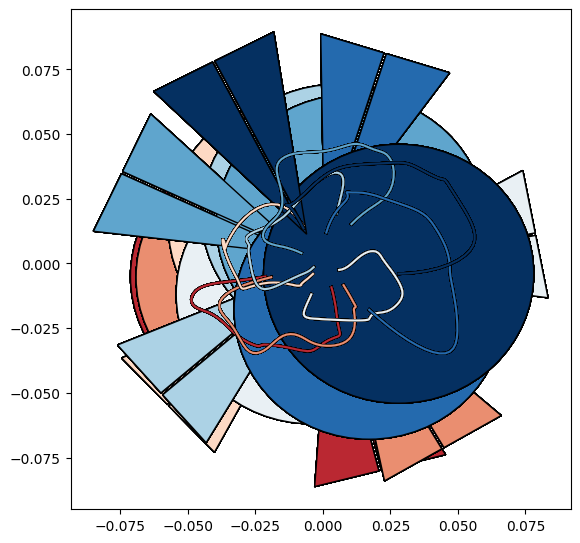

In [264]:
import jPCA
from jPCA.util import load_churchland_data, plot_projections, preprocess

# Create a jPCA object
jpca_prep = jPCA.JPCA(num_jpcs=2)
jpca_exec = jPCA.JPCA(num_jpcs=2)

times_prep = list(np.arange(spikes_prep.shape[1]))
times_exec = list(np.arange(spikes_exec.shape[1]))
tstart = 0

# Fit the jPCA object to data
(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt) = jpca_prep.fit(list(spike_data_prep),times=times_prep, tstart=tstart, tend=np.max(times_prep))

(projected,
    full_data_var,
    pca_var_capt,
    jpca_var_capt) = jpca_exec.fit(list(spike_data_exec),times=times_exec, tstart=tstart, tend=np.max(times_exec))

# Plot the projected data
plot_projections(projected)


In [265]:
datas = spike_data_prep
processed_datas, full_data_var, pca_var_capt = \
            preprocess(datas, times, tstart=tstart, tend=tend, pca=True,
                       subtract_cc_mean=True, num_pcs=6)
        
projected, jpca_var_capt = jpca_prep.project(processed_datas)

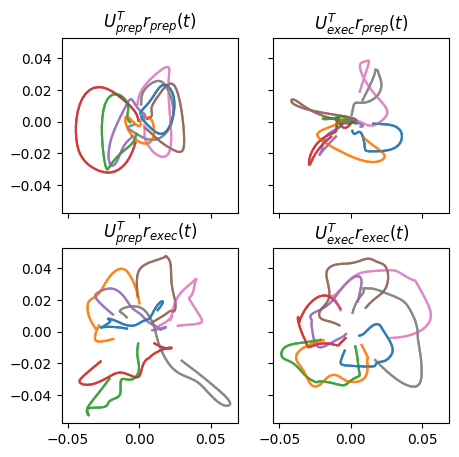

In [266]:
# apply jPCA to prep/exec data
fig, axes = plt.subplots(2, 2, figsize=(5, 5),sharex=True,sharey=True)

for i, (X,dl,times) in enumerate(zip([spike_data_prep,spike_data_exec],['prep','exec'],[times_prep,times_exec])):
    datas = X
    processed_datas, full_data_var, pca_var_capt = \
                preprocess(datas, times, tstart=tstart, tend=np.max(times), pca=True,
                        subtract_cc_mean=True, num_pcs=6)
            
    projected, jpca_var_capt = jpca_prep.project(processed_datas)
    traj = projected
    for t,d in zip(traj,dir_index):
        axes[i,0].plot(*t.T,c=f"C{d}",alpha=0.1)
    str = '$U^T_{prep}r_{' + dl + '}(t)$'
    axes[i,0].set_title(label=rf'{str}')
    datas = X
    processed_datas, full_data_var, pca_var_capt = \
                preprocess(datas, times, tstart=tstart, tend=np.max(times), pca=True,
                        subtract_cc_mean=True, num_pcs=6)
            
    projected, jpca_var_capt = jpca_exec.project(processed_datas)
    traj = projected
    for t,d in zip(traj,dir_index):
        axes[i,1].plot(*t.T,c=f"C{d}",alpha=0.1)
    str = '$U^T_{exec}r_{' + dl + '}(t)$'
    axes[i,1].set_title(label=rf'{str}')


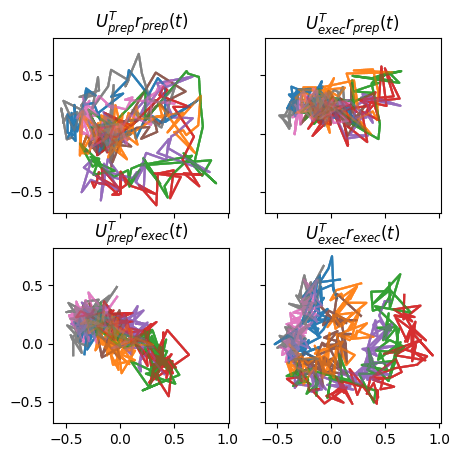

In [185]:
# apply PCA to prep/exec data
fig, axes = plt.subplots(2, 2, figsize=(5, 5),sharex=True,sharey=True)

for i, (X,dl) in enumerate(zip([spike_data_prep,spike_data_exec],['prep','exec'])):
    traj = pca_prep.transform(np.concatenate(X, axis=0)).reshape((*X.shape[:-1],-1))
    for t,d in zip(traj,dir_index):
        axes[i,0].plot(*t.T,c=f"C{d}",alpha=0.1)
    str = '$U^T_{prep}r_{' + dl + '}(t)$'
    axes[i,0].set_title(label=rf'{str}')
    traj = pca_exec.transform(np.concatenate(X, axis=0)).reshape((*X.shape[:-1],-1))
    for t,d in zip(traj,dir_index):
        axes[i,1].plot(*t.T,c=f"C{d}",alpha=0.1)
    str = '$U^T_{exec}r_{' + dl + '}(t)$'
    axes[i,1].set_title(label=rf'{str}')


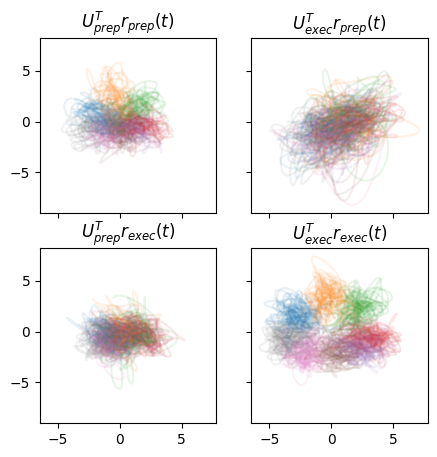

In [178]:
# apply PCA to prep/exec data
fig, axes = plt.subplots(2, 2, figsize=(5, 5),sharex=True,sharey=True)

for i, (X,dl) in enumerate(zip([spike_data_prep,spike_data_exec],['prep','exec'])):
    traj = lda_prep.transform(np.concatenate(X, axis=0)).reshape((*X.shape[:-1],-1))
    for t,d in zip(traj,dir_index):
        axes[i,0].plot(*t.T,c=f"C{d}",alpha=0.1)
    str = '$U^T_{prep}r_{' + dl + '}(t)$'
    axes[i,0].set_title(label=rf'{str}')
    traj = lda_exec.transform(np.concatenate(X, axis=0)).reshape((*X.shape[:-1],-1))
    for t,d in zip(traj,dir_index):
        axes[i,1].plot(*t.T,c=f"C{d}",alpha=0.1)
    str = '$U^T_{exec}r_{' + dl + '}(t)$'
    axes[i,1].set_title(label=rf'{str}')


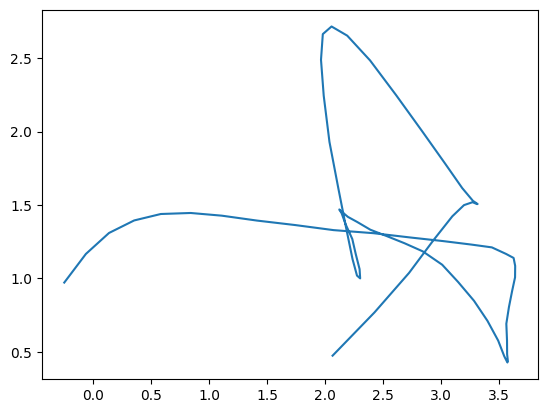

In [170]:
plt.plot(*traj[1].T)